<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

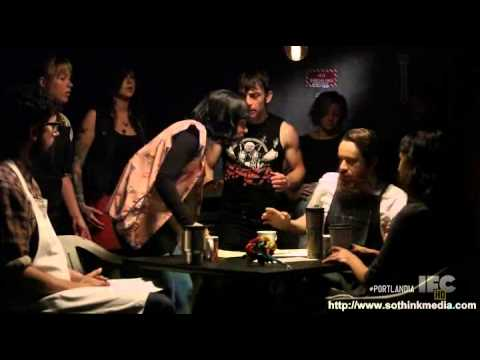

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'C:\\Users\\Z Dubs\\lambda\\DS-Unit-4-Sprint-1-NLP-master\\module1-text-data'

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [4]:
# Start here 

# Explore the csv data 
print(shops.shape)
print(shops.dtypes)
shops['full_review_text'][0]

(7616, 3)
coffee_shop_name    object
full_review_text    object
star_rating         object
dtype: object


' 11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes!  I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas? '

In [5]:
# Prepping upcoming string split
reviews = shops['full_review_text'].tolist()
reviews[0]

' 11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes!  I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas? '

---

Plan to clean data 

1. Split date from 'full_review_text' and move into own column
2. Remove space that starts off every review
3. Maybe do something about the 'x check-in'/'listed in' that pops up in some reviews 
4. Convert star_rating column from str to int  
5. Convert all text to lowercase 

---

In [6]:
# Split the date and review, leaving just the review in the column
shops['full_review_text'] = [s.split(None, 1)[-1] for s in reviews]
shops['full_review_text']

0       1 check-in Love love loved the atmosphere! Eve...
1       Listed in Date Night: Austin, Ambiance in Aust...
2       1 check-in Listed in Brunch Spots I loved the ...
3       Very cool decor! Good drinks Nice seating  How...
4       1 check-in They are located within the Northcr...
                              ...                        
7611    I actually step into this restaurant by chance...
7612    Ok, The Steeping Room IS awesome. How do they ...
7613    Loved coming here for tea, and the atmosphere ...
7614    The food is just average. The booths didn't fe...
7615    I finally stopped in for lunch with my colleag...
Name: full_review_text, Length: 7616, dtype: object

In [7]:
print(shops['full_review_text'][0])

1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes!  I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas? 


---

Great, no more blankspace problem in the beginning of the reviews column, lets see if we can get the date back in its own column

---

In [8]:
# Take the removed date and append it to the df 
review_date = [s.split(None, 1)[0] for s in reviews]
shops['review_date'] = review_date[1]
shops

,coffee_shop_name,full_review_text,star_rating,review_date
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Eve...,5.0 star rating,12/2/2016
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4.0 star rating,12/2/2016
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the ...,4.0 star rating,12/2/2016
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating How...,2.0 star rating,12/2/2016
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northcr...,4.0 star rating,12/2/2016
...,...,...,...,...
7611,The Steeping Room,I actually step into this restaurant by chance...,4.0 star rating,12/2/2016
7612,The Steeping Room,"Ok, The Steeping Room IS awesome. How do they ...",5.0 star rating,12/2/2016
7613,The Steeping Room,"Loved coming here for tea, and the atmosphere ...",4.0 star rating,12/2/2016
7614,The Steeping Room,The food is just average. The booths didn't fe...,3.0 star rating,12/2/2016


In [9]:
# Convert 'review_date' column to datetime
shops['review_date'] = pd.to_datetime(shops['review_date'])
shops.dtypes

coffee_shop_name            object
full_review_text            object
star_rating                 object
review_date         datetime64[ns]
dtype: object

---

Poifect, now to convert the star_rating column from str to int

---

In [10]:
# Get rid of all non-numerics in the column 
shops['star_rating'] = shops['star_rating'].str.replace('[a-zA-Z]', '')
shops['star_rating']

0        5.0   
1        4.0   
2        4.0   
3        2.0   
4        4.0   
         ...   
7611     4.0   
7612     5.0   
7613     4.0   
7614     3.0   
7615     4.0   
Name: star_rating, Length: 7616, dtype: object

In [11]:
# Convert column to numeric (float in this case)
shops['star_rating'] = shops['star_rating'].astype(float)
shops

,coffee_shop_name,full_review_text,star_rating,review_date
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Eve...,5.0,2016-12-02
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4.0,2016-12-02
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the ...,4.0,2016-12-02
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating How...,2.0,2016-12-02
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northcr...,4.0,2016-12-02
...,...,...,...,...
7611,The Steeping Room,I actually step into this restaurant by chance...,4.0,2016-12-02
7612,The Steeping Room,"Ok, The Steeping Room IS awesome. How do they ...",5.0,2016-12-02
7613,The Steeping Room,"Loved coming here for tea, and the atmosphere ...",4.0,2016-12-02
7614,The Steeping Room,The food is just average. The booths didn't fe...,3.0,2016-12-02


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [12]:
# Lets start by tokenizing the review column
# I'll just borrow some code from lecture
# Define a function to parse the strings into a list of words
import re
def tokenize(text):
    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = tokens.lower().split()
    return tokens

In [13]:
# Apply the tokenize function 

shops['tokens'] = shops['full_review_text'].apply(tokenize)
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date,tokens
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Eve...,5.0,2016-12-02,"[1, checkin, love, love, loved, the, atmospher..."
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4.0,2016-12-02,"[listed, in, date, night, austin, ambiance, in..."
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the ...,4.0,2016-12-02,"[1, checkin, listed, in, brunch, spots, i, lov..."
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating How...,2.0,2016-12-02,"[very, cool, decor, good, drinks, nice, seatin..."
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northcr...,4.0,2016-12-02,"[1, checkin, they, are, located, within, the, ..."


In [14]:
# Now that we've tokenized, lets trying taking the count
from collections import Counter

counts = Counter()

shops['tokens'].apply(lambda x: counts.update(x))

counts.most_common(10)

[('the', 34809),
 ('and', 26650),
 ('a', 22755),
 ('i', 20237),
 ('to', 17164),
 ('of', 12600),
 ('is', 11999),
 ('coffee', 10353),
 ('was', 9707),
 ('in', 9546)]

In [15]:
# Borrow some more code for counts
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [16]:
# Lets see what it gives us 
wc = count(shops['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
50,the,6847,34809,1.0,0.044975,0.044975,0.899028
54,and,6864,26650,2.0,0.034433,0.079408,0.901261
18,a,6246,22755,3.0,0.029401,0.108809,0.820116
68,i,5528,20237,4.0,0.026147,0.134956,0.725840
45,to,5653,17164,5.0,0.022177,0.157132,0.742253


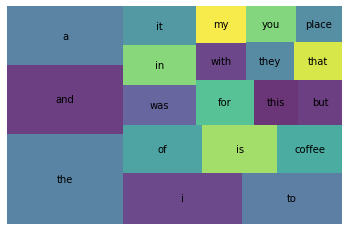

In [17]:
# Word count visualization for visual comprehension 
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [18]:
# Now lets process some raw text with spacy 
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [19]:
# Tokenizer Pipe
tokens = []

""" Make them tokens """
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

shops['tokens'] = tokens
shops['tokens']

0       [1, check-in, Love, love, loved, the, atmosphe...
1       [Listed, in, Date, Night:, Austin,, Ambiance, ...
2       [1, check-in, Listed, in, Brunch, Spots, I, lo...
3       [Very, cool, decor!, Good, drinks, Nice, seati...
4       [1, check-in, They, are, located, within, the,...
                              ...                        
7611    [I, actually, step, into, this, restaurant, by...
7612    [Ok,, The, Steeping, Room, IS, awesome., How, ...
7613    [Loved, coming, here, for, tea,, and, the, atm...
7614    [The, food, is, just, average., The, booths, d...
7615    [I, finally, stopped, in, for, lunch, with, my...
Name: tokens, Length: 7616, dtype: object

In [20]:
# Alright, lets take another counts and see what changed
wc = count(shops['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
57,the,6520,27779,1.0,0.034993,0.034993,0.856092
60,and,6804,25748,2.0,0.032434,0.067427,0.893382
19,a,6181,22085,3.0,0.027820,0.095247,0.811581
39,I,5469,19780,4.0,0.024916,0.120163,0.718093
53,to,5631,16904,5.0,0.021294,0.141457,0.739364


In [22]:
# Turns out not much
# Lets update the tokens by removing stop words
tokens = []
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = []
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)

shops['tokens'] = tokens
shops['tokens']

0       [1, check-in, love, love, loved, atmosphere!, ...
1       [listed, date, night:, austin,, ambiance, aust...
2       [1, check-in, listed, brunch, spots, loved, ec...
3       [cool, decor!, good, drinks, nice, seating,  ,...
4       [1, check-in, located, northcross, mall, shopp...
                              ...                        
7611    [actually, step, restaurant, chance, favorites...
7612    [ok,, steeping, room, awesome., great, menu, i...
7613    [loved, coming, tea,, atmosphere, pretty, fres...
7614    [food, average., booths, didn't, feel, clean.,...
7615    [finally, stopped, lunch, colleague, i'm, glad...
Name: tokens, Length: 7616, dtype: object

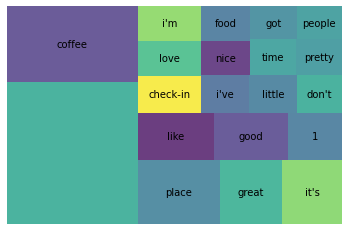

In [23]:
# Visualize results post stop-word removal 
wc = count(shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [30]:
# Better, but you can still see some stop words in there
# Lets extend the stop words 
STOP_WORDS = nlp.Defaults.stop_words.union([" ", "i'm",'1', "it's", 'got', "i've", "check-in", 'listed', '-'])

In [31]:
# Rerun the tokenizer to update results with newly-added stop words
tokens = []
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = []
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens
wc = count(shops['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
31,coffee,4210,8058,1.0,0.021132,0.021132,0.552784
148,place,3029,4264,2.0,0.011182,0.032314,0.397715
110,great,2438,3250,3.0,0.008523,0.040838,0.320116
167,like,2034,2902,4.0,0.007610,0.048448,0.267069
175,good,2084,2779,5.0,0.007288,0.055736,0.273634


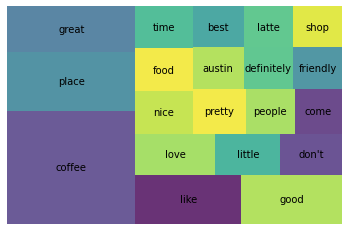

In [32]:
# Another visualization for the same reason
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [38]:
# Alright, hopefully last step, lemmatization
# Continue the theme of borrowing code from lecture
def get_lemmas(text):
    lemmas = []
    doc = nlp(text)
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    return lemmas
# Apply the function to the data
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)
shops['lemmas']

0       [1, check, Love, love, love, atmosphere, corne...
1       [list, Date, Night, Austin, Ambiance, Austin, ...
2       [1, check, list, Brunch, Spots, love, eclectic...
3       [cool, decor, good, drink, nice, seating,  ,  ...
4       [1, check, locate, Northcross, mall, shopping,...
                              ...                        
7611    [actually, step, restaurant, chance, favorite,...
7612    [ok, Steeping, Room, awesome, great, menu, ite...
7613    [love, come, tea, atmosphere, pretty, fresh, o...
7614    [food, average, booth, feel, clean, waitstaff,...
7615    [finally, stop, lunch, colleague, glad, delici...
Name: lemmas, Length: 7616, dtype: object

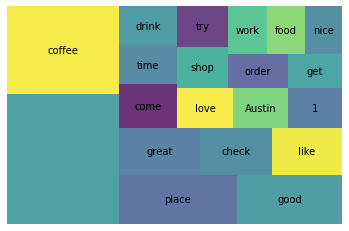

In [39]:
# Hopefully my last visualization
# Visualize the overall top words using lemmatization
wc = count(shops['lemmas'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [36]:
# Alright, we're getting somewhere!
# Lets seperate the 'good' shops from the 'bad' shops to prepare for the next section
good_shops = shops[shops['star_rating']>=4]
bad_shops = shops[shops['star_rating']<=3]

# Proof df was altered correctly
print(good_shops)

# Visualize df shapes
print(bad_shops.shape)

                     coffee_shop_name  \
0     The Factory - Cafe With a Soul    
1     The Factory - Cafe With a Soul    
2     The Factory - Cafe With a Soul    
4     The Factory - Cafe With a Soul    
5     The Factory - Cafe With a Soul    
...                               ...   
7610               The Steeping Room    
7611               The Steeping Room    
7612               The Steeping Room    
7613               The Steeping Room    
7615               The Steeping Room    

                                       full_review_text  star_rating  \
0     1 check-in Love love loved the atmosphere! Eve...          5.0   
1     Listed in Date Night: Austin, Ambiance in Aust...          4.0   
2     1 check-in Listed in Brunch Spots I loved the ...          4.0   
4     1 check-in They are located within the Northcr...          4.0   
5     1 check-in Very cute cafe! I think from the mo...          4.0   
...                                                 ...          ...   
761

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [44]:
# Lets see what it gives us 
wc = count(good_shops['tokens'])
wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
31,coffee,3383,6421,1.0,0.021641,0.021641,0.550977
148,place,2432,3389,2.0,0.011422,0.033063,0.396091
110,great,2174,2902,3.0,0.009781,0.042844,0.354072
313,good,1643,2180,4.0,0.007347,0.050192,0.267590
212,like,1486,2068,5.0,0.006970,0.057162,0.242020
25,love,1263,1604,6.0,0.005406,0.062568,0.205700
599,little,1027,1230,7.0,0.004146,0.066713,0.167264
244,nice,962,1101,8.0,0.003711,0.070424,0.156678
375,best,951,1093,9.0,0.003684,0.074108,0.154886
193,friendly,986,1014,10.0,0.003418,0.077525,0.160586


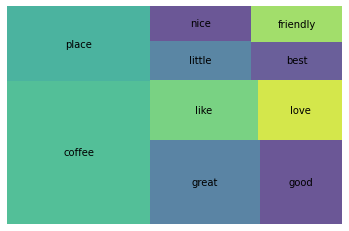

In [47]:
# Visualize top 10 words for 'good shops'
wc = count(good_shops['tokens'])
wc_top10 = wc[wc['rank'] <= 10]
squarify.plot(sizes=wc_top10['pct_total'], label=wc_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [46]:
# Lets see what it gives us 
wc = count(bad_shops['tokens'])
wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
28,coffee,827,1637,1.0,0.019347,0.019347,0.560298
165,place,597,875,2.0,0.010341,0.029688,0.404472
13,like,548,834,3.0,0.009857,0.039545,0.371274
21,good,441,599,4.0,0.007079,0.046624,0.298780
204,don't,340,430,5.0,0.005082,0.051706,0.230352
151,food,266,369,6.0,0.004361,0.056067,0.180217
246,time,264,351,7.0,0.004148,0.060215,0.178862
119,pretty,278,349,8.0,0.004125,0.064340,0.188347
109,great,264,348,9.0,0.004113,0.068453,0.178862
498,people,247,327,10.0,0.003865,0.072317,0.167344


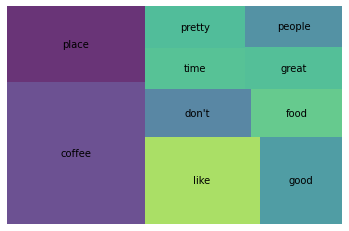

In [48]:
# Visualize top 10 words for 'bad shops'
wc = count(bad_shops['tokens'])
wc_bottom10 = wc[wc['rank'] <= 10]
squarify.plot(sizes=wc_bottom10['pct_total'], label=wc_bottom10['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

